In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score,roc_auc_score
from sklearn.metrics import precision_recall_curve,roc_curve,confusion_matrix , auc

import FinanceDataReader as fdr

import warnings
warnings.filterwarnings("ignore")

In [14]:
# 모델링 함수

def model_basic(x_train, y_train, x_test, y_test): 
    models = [
         LogisticRegression(C=0.005,max_iter=100,penalty='l2',solver='liblinear',random_state=1,l1_ratio=0.5),
         LinearDiscriminantAnalysis(priors=[0.9619025629184945, 0.038097437081505425], solver='lsqr',shrinkage= 'auto'),
         GaussianNB(priors=[0.9619025629184945, 0.038097437081505425]),
         RandomForestClassifier(random_state=1,class_weight=None, max_depth=15, max_features =  'sqrt', min_samples_leaf= 1, min_samples_split= 10, n_estimators= 100),
         XGBClassifier(random_state=1,class_weight='balanced_subsample', colsample_bytree= 0.9, gamma= 0, learning_rate= 0.01, max_depth=15, min_child_weight= 1, n_estimators= 100, subsample= 0.9)
    ]

    rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


    for clf in models:
        clf = clf.fit(x_train, y_train)
    #1열:Train
        y_hat = clf.predict(x_train)
        y_proba = clf.predict_proba(x_train)[:,1].reshape(-1,1)
        results_train  = (round(accuracy_score(y_train,y_hat),2),round(roc_auc_score(y_train,y_proba),2))
    #2열:Test
        y_hat = clf.predict(x_test)
        y_proba = clf.predict_proba(x_test)[:,1].reshape(-1,1)
        results = (round(accuracy_score(y_test,y_hat),2),
                        round(precision_score(y_test,y_hat),2),
                        round(recall_score(y_test,y_hat),2),
                        round(f1_score(y_test,y_hat),2),
                        round(roc_auc_score(y_test,y_proba),2))

        rdict['model'].append(clf); 
        rdict['acc_train'].append(results_train[0])
        rdict['auc_train'].append(results_train[1])
        
        rdict['acc_test'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['AUC_test'].append(results[4])   

        confusion = confusion_matrix(y_test, y_hat)

        print(confusion)

    rdf_final = pd.DataFrame(data=rdict)
    return rdf_final


In [3]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()



In [8]:
def plot_pr_auc_curve(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    # Plot the PR-AUC curve
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-AUC Curve')
    plt.legend()
    plt.show()

def get_pr_auc_score(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    return pr_auc



In [2]:
## 불균형 처리 안한 데이터 
train = pd.read_csv("./data/전처리완료/코스닥_train원본.csv", index_col=0)
test =  pd.read_csv("./data/전처리완료/코스닥_test원본.csv",index_col=0)

train = train.sort_values(by=['회계년도'],ascending=True)
test = test.sort_values(by=['회계년도'],ascending=True)

train.rename(columns={'abs(영업현금흐름-당기순이익)/매출액': 'CND'},inplace=True)
test.rename(columns={'abs(영업현금흐름-당기순이익)/매출액': 'CND'},inplace=True)

id_col = ['회사명', '거래소코드', '회계년도', '산업군','target_3']
최종_col_3 = ['CND', '누적수익성비율', 'WW지수','금융비용부담률', 'TMD', '순운전자본비율']


train_x = train[최종_col_3]
train_y = train["target_3"]

test_x = test[최종_col_3]
test_y = test["target_3"]

<Axes: title={'center': 'Correlation of Features'}>

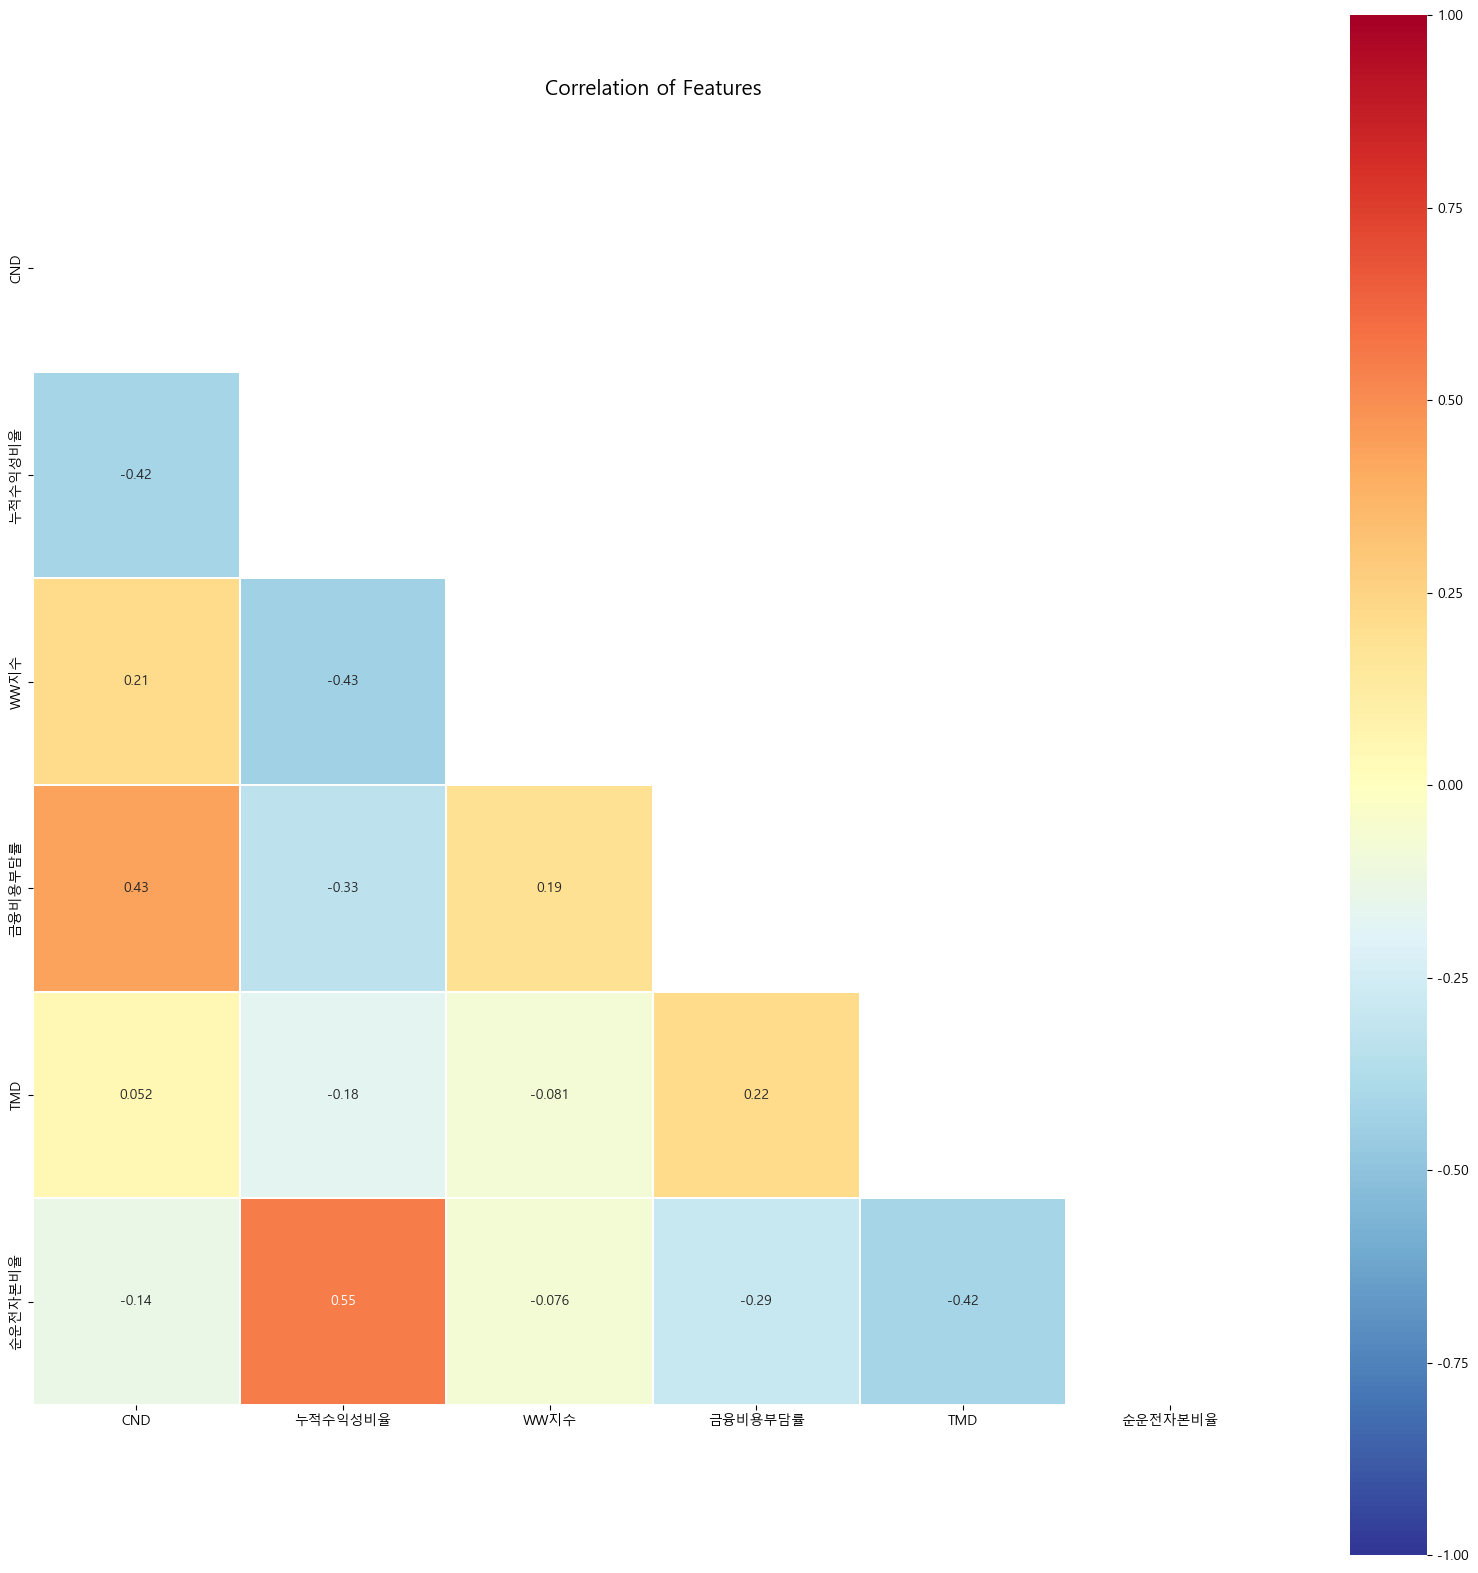

In [6]:
# 최종변수 히트맵

colormap = plt.cm.hot

corr = train_x.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

---
## LOGISTIC

In [7]:
c = train_y.value_counts(property)
c

target_3
0    0.961903
1    0.038097
Name: proportion, dtype: float64

In [78]:
# 로지스틱 그리드 서치

lr=LogisticRegression(random_state=1,n_jobs=-1,)
param = {
    'solver' :['lbfgs', 'liblinear','sag', 'saga'],
    'C': [0.001,0.005,0.01,0.1,0.5, 1,5,7],
    'penalty': ['l2','l1'],
    'max_iter':[100,130,150,170,180,200],
    'class_weight':[None,'balanced'],
    'l1_ratio':[0.5,0.6,0.4,0.1]
}
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)

grid_lr = GridSearchCV(lr,n_jobs=-1,scoring='f1',cv=cv,param_grid=param,refit=True)
grid_lr.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_lr.cv_results_)
scores_df[scores_df['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_l1_ratio,param_max_iter,param_penalty,param_solver,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
385,0.029319,0.004365,0.015845,0.006238,0.005,None,0.5,100,l2,liblinear,...,0.540541,0.736842,0.736842,0.666667,0.684211,0.666667,0.702703,0.676353,0.061768,1
393,0.025792,0.002419,0.012167,0.001429,0.005,None,0.5,130,l2,liblinear,...,0.540541,0.736842,0.736842,0.666667,0.684211,0.666667,0.702703,0.676353,0.061768,1
401,0.029459,0.005016,0.013711,0.003124,0.005,None,0.5,150,l2,liblinear,...,0.540541,0.736842,0.736842,0.666667,0.684211,0.666667,0.702703,0.676353,0.061768,1
409,0.026127,0.005359,0.010040,0.003401,0.005,None,0.5,170,l2,liblinear,...,0.540541,0.736842,0.736842,0.666667,0.684211,0.666667,0.702703,0.676353,0.061768,1
417,0.033690,0.010848,0.018215,0.013822,0.005,None,0.5,180,l2,liblinear,...,0.540541,0.736842,0.736842,0.666667,0.684211,0.666667,0.702703,0.676353,0.061768,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,0.026337,0.002139,0.009785,0.002724,0.1,None,0.1,130,l1,liblinear,...,0.540541,0.736842,0.736842,0.666667,0.684211,0.666667,0.702703,0.676353,0.061768,1
1317,0.031873,0.006426,0.008553,0.002591,0.1,None,0.1,150,l1,liblinear,...,0.540541,0.736842,0.736842,0.666667,0.684211,0.666667,0.702703,0.676353,0.061768,1
1325,0.026624,0.003158,0.009207,0.003114,0.1,None,0.1,170,l1,liblinear,...,0.540541,0.736842,0.736842,0.666667,0.684211,0.666667,0.702703,0.676353,0.061768,1
1333,0.030731,0.007197,0.009095,0.002359,0.1,None,0.1,180,l1,liblinear,...,0.540541,0.736842,0.736842,0.666667,0.684211,0.666667,0.702703,0.676353,0.061768,1


In [79]:
print(grid_lr.best_params_)
pred_lr = grid_lr.predict(test_x)
pred_prob_lr = grid_lr.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred_lr,test=test_y)

{'C': 0.005, 'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
##############
 [[2358   12]
 [  21   51]] ############
 acc_score: 0.9864864864864865
 f1_score: 0.7555555555555556 
 precision: 0.8095238095238095 
 recall: 0.7083333333333334


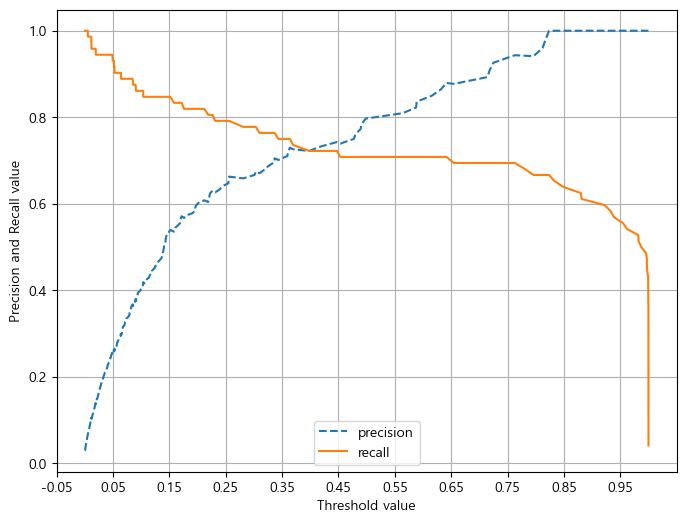

In [80]:
precision_recall_curve_plot(test_y,pred_prob_lr)

In [97]:
get_eval_by_threshold(test_y,pred_prob_lr,[0.36])

임곗값: 0.36
##############
 [[2349   21]
 [  18   54]] ############
 acc_score: 0.984029484029484
 f1_score: 0.7346938775510204 
 precision: 0.72 
 recall: 0.75


In [ ]:
plot_pr_auc_curve(test_y,pred_prob_lr)
get_pr_auc_score(test_y,pred_prob_lr)

## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob_lr)
auc_score = roc_auc_score(test_y,pred_prob_lr)
print(f'auc 값: {np.round(auc_score,4)}')

---
## LDA

In [13]:
proi = train_y.value_counts(property)

In [14]:
lda = LinearDiscriminantAnalysis()
param = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None,'auto'],
    'priors': [[proi[0],proi[1]],None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_lda = GridSearchCV(lda, param_grid=param, scoring='f1', cv=cv, n_jobs=-1, refit=True)
grid_lda.fit(train_x, train_y)

scores_df = pd.DataFrame(grid_lda.cv_results_)
scores_df.loc[:, 'param_solver':'mean_test_score']


,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
0,svd,"{'priors': [0.9619025629184945, 0.038097437081...",0.541667,0.640000,0.595745,0.615385,0.583333,0.595226
1,lsqr,"{'priors': [0.9619025629184945, 0.038097437081...",0.541667,0.640000,0.595745,0.615385,0.583333,0.595226
2,eigen,"{'priors': [0.9619025629184945, 0.038097437081...",0.541667,0.640000,0.595745,0.615385,0.583333,0.595226
3,svd,"{'priors': [0.9619025629184945, 0.038097437081...",NaN,NaN,NaN,NaN,NaN,NaN
4,lsqr,"{'priors': [0.9619025629184945, 0.038097437081...",0.581818,0.615385,0.625000,0.615385,0.640000,0.615517
5,eigen,"{'priors': [0.9619025629184945, 0.038097437081...",0.581818,0.615385,0.625000,0.615385,0.640000,0.615517
6,svd,"{'priors': None, 'shrinkage': None, 'solver': ...",0.541667,0.640000,0.595745,0.615385,0.583333,0.595226
7,lsqr,"{'priors': None, 'shrinkage': None, 'solver': ...",0.541667,0.640000,0.595745,0.615385,0.583333,0.595226
8,eigen,"{'priors': None, 'shrinkage': None, 'solver': ...",0.541667,0.640000,0.595745,0.615385,0.583333,0.595226
9,svd,"{'priors': None, 'shrinkage': 'auto', 'solver'...",NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print(grid_lda.best_params_)
pred_lda = grid_lda.predict(test_x)
pred_prob_lda = grid_lda.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred_lda,test=test_y)

{'priors': [0.9619025629184945, 0.038097437081505425], 'shrinkage': 'auto', 'solver': 'lsqr'}
##############
 [[2352   18]
 [  21   51]] ############
 acc_score: 0.984029484029484
 f1_score: 0.723404255319149 
 precision: 0.7391304347826086 
 recall: 0.7083333333333334


In [18]:
get_eval_by_threshold(test_y,pred_prob_lda,[0.44])

임곗값: 0.44
##############
 [[2351   19]
 [  20   52]] ############
 acc_score: 0.984029484029484
 f1_score: 0.7272727272727272 
 precision: 0.7323943661971831 
 recall: 0.7222222222222222


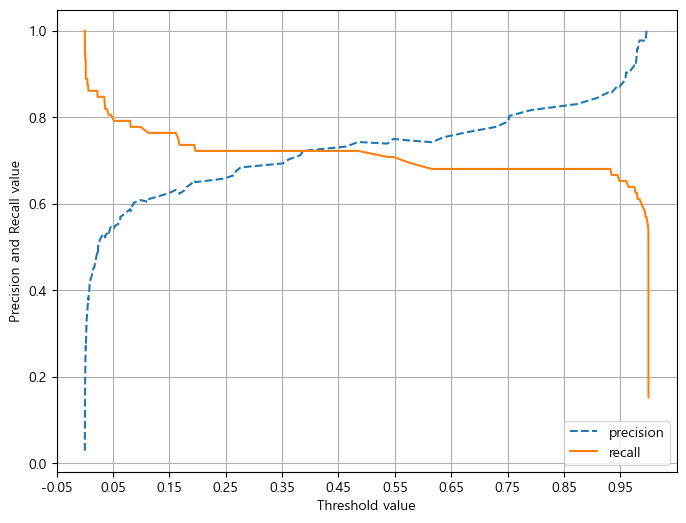

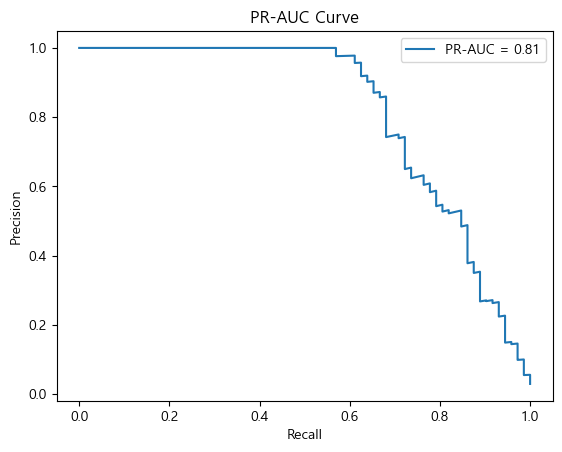

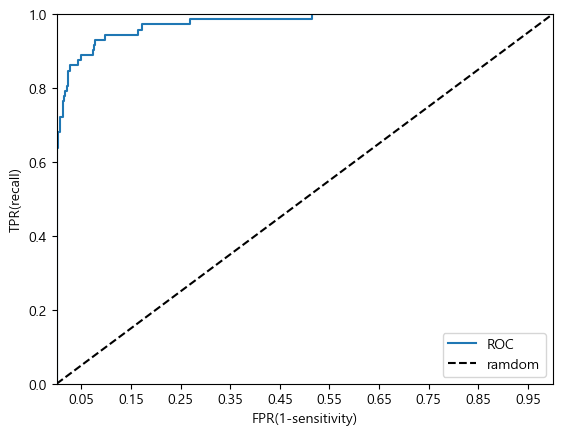

auc 값: 0.9756


In [19]:
precision_recall_curve_plot(test_y,pred_prob_lda)

plot_pr_auc_curve(test_y,pred_prob_lda)
get_pr_auc_score(test_y,pred_prob_lda)

## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob_lda)
auc_score = roc_auc_score(test_y,pred_prob_lda)
print(f'auc 값: {np.round(auc_score,4)}')

---
## Gaussian_NB

In [19]:
a = train_y.value_counts(property)
a

target_3
0    0.961903
1    0.038097
Name: proportion, dtype: float64

In [21]:
nb=GaussianNB(priors=[a[0],a[1]])

nb.fit(train_x,train_y)

pred = nb.predict(test_x)
pred_prob = nb.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

##############
 [[2281   89]
 [  12   60]] ############
 acc_score: 0.9586404586404587
 f1_score: 0.5429864253393666 
 precision: 0.40268456375838924 
 recall: 0.8333333333333334


In [25]:
get_eval_by_threshold(test_y,pred_prob,[0.7])

임곗값: 0.7
##############
 [[2289   81]
 [  12   60]] ############
 acc_score: 0.961916461916462
 f1_score: 0.5633802816901409 
 precision: 0.425531914893617 
 recall: 0.8333333333333334


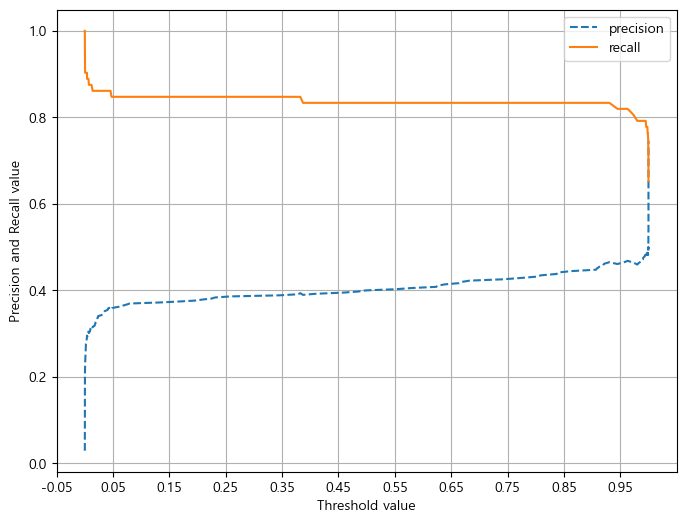

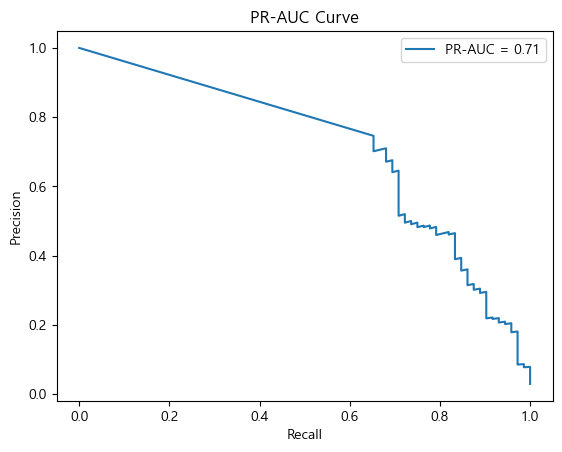

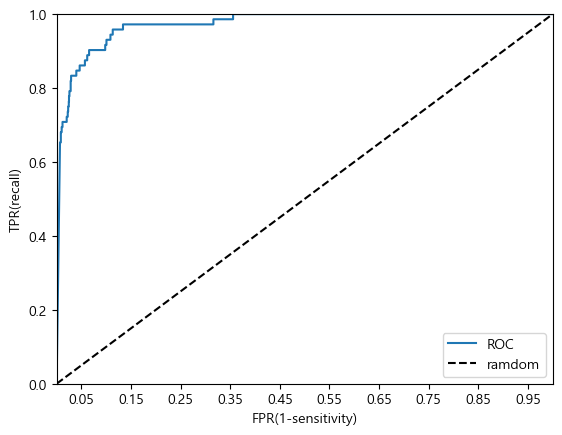

auc 값: 0.9733


In [29]:
precision_recall_curve_plot(test_y , pred_prob)

plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

---
## RandomForest

In [20]:
rf=RandomForestClassifier(random_state=1,n_jobs=-1)
param = {
    'class_weight' :[None,'balanced'],
    'n_estimators': [50, 100],
    'max_depth': [10,15,20,25,30],
    'min_samples_split': [ 5,7, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_rf = GridSearchCV(rf,n_jobs=-1,scoring='f1',cv=cv,param_grid=param,refit=True)
grid_rf.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_rf.cv_results_)
scores_df[scores_df['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.57199,0.122326,0.234911,0.094015,None,10,sqrt,2,5,70,"{'class_weight': None, 'max_depth': 10, 'max_f...",0.679245,0.705882,0.641509,0.703704,0.666667,0.679401,0.024041,1


In [21]:
print(grid_rf.best_params_)
pred = grid_rf.predict(test_x)
pred_prob = grid_rf.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 70}
##############
 [[2365    5]
 [  20   52]] ############
 acc_score: 0.9897624897624898
 f1_score: 0.8062015503875969 
 precision: 0.9122807017543859 
 recall: 0.7222222222222222


In [12]:
get_eval_by_threshold(test_y,pred_prob,[0.3])

임곗값: 0.3
##############
 [[2339   31]
 [  15   57]] ############
 acc_score: 0.9811629811629812
 f1_score: 0.7124999999999999 
 precision: 0.6477272727272727 
 recall: 0.7916666666666666


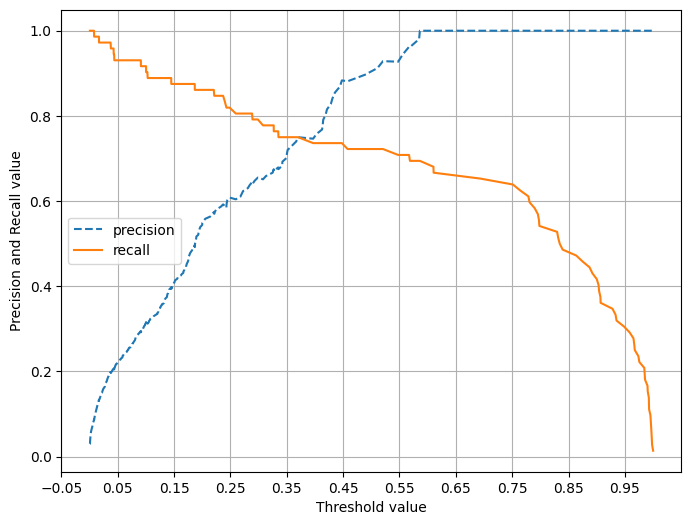

In [23]:
precision_recall_curve_plot(test_y,pred_prob)

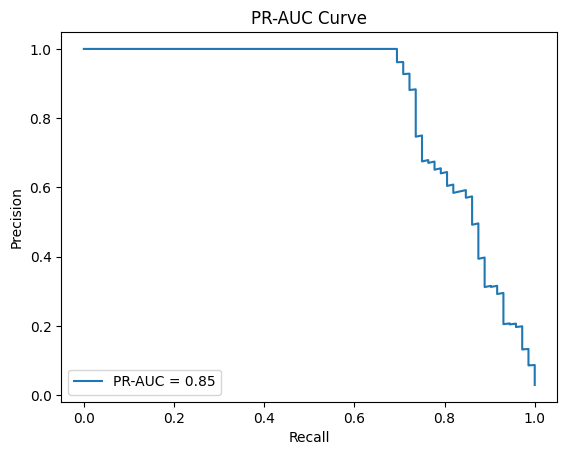

0.8494449370930278

In [24]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

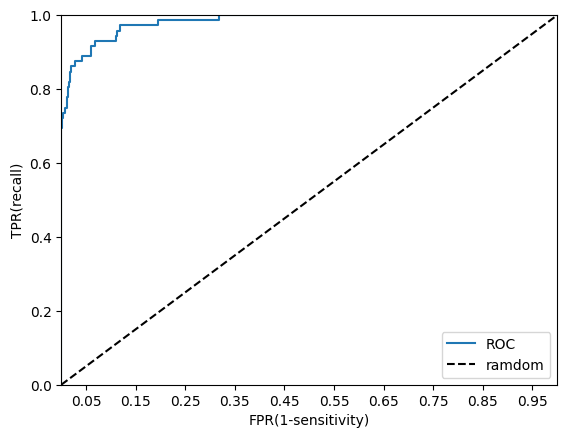

auc 값: 0.9828


In [25]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

----------------------------------------------------------
## xgboost

In [ ]:
xgb = XGBClassifier(random_state=1, n_jobs=-1)
param = {
    'class_weight': ['balanced_subsample', 'balanced',None],
    'n_estimators': [50,100],
    'max_depth': [ 10,15,20,25],
    'min_child_weight': [1, 3],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_xgb = GridSearchCV(xgb, n_jobs=-1, scoring='f1', cv=cv, param_grid=param, refit=True)
grid_xgb.fit(train_x, train_y)

scores_df = pd.DataFrame(grid_xgb.cv_results_)
print(scores_df.iloc[:, 4:])


[11:19:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

     param_class_weight param_colsample_bytree param_gamma  \
0    balanced_subsample                    0.7           0   
1    balanced_subsample                    0.7           0   
2    balanced_subsample                    0.7           0   
3    balanced_subsample                    0.7           0   
4    balanced_subsample                    0.7           0   
..                  ...                    ...         ...   
859                None                    0.9           0   
860                None                    0.9           0   
861                None                    0.9           0   
862                None                    0.9           0   
863                None                    0.9           0   

    param_learning_rate param_max_depth param_min_chi

In [ ]:
print(grid_xgb.best_params_)
pred = grid_xgb.predict(test_x)
pred_prob = grid_xgb.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'class_weight': 'balanced_subsample', 'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
##############
 [[2468    9]
 [  21   51]] ############
 acc_score: 0.9882306786975285
 f1_score: 0.7727272727272727 
 precision: 0.85 
 recall: 0.7083333333333334


In [ ]:
get_eval_by_threshold(test_y,pred_prob,[0.44])

임곗값: 0.44
##############
 [[2459   18]
 [  20   52]] ############
 acc_score: 0.9850921930168693
 f1_score: 0.732394366197183 
 precision: 0.7428571428571429 
 recall: 0.7222222222222222


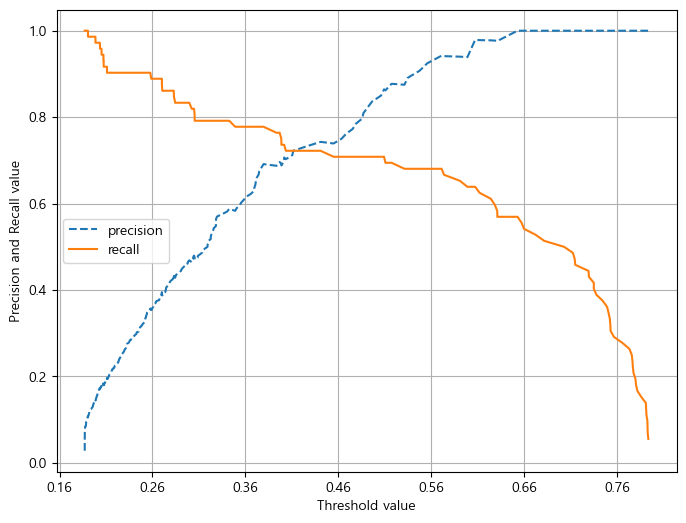

In [ ]:
precision_recall_curve_plot(test_y,pred_prob)

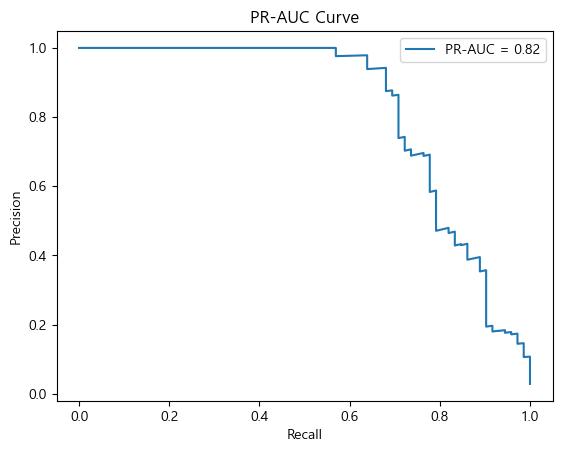

0.8212751037260502

In [ ]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

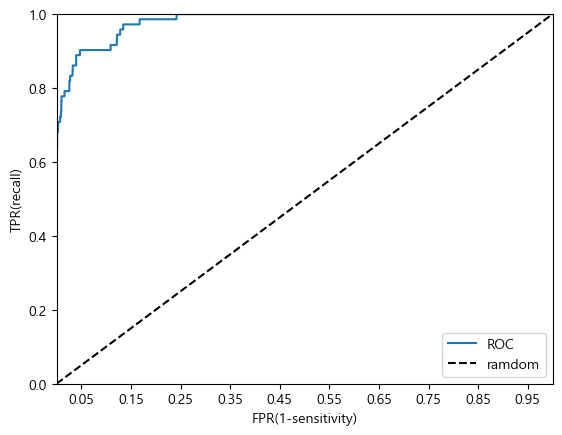

auc 값: 0.981


In [ ]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

---------------
# 임계값 조정안하고 하이퍼파라미터만 조정

In [15]:
## 
model_basic(train_x,train_y,test_x,test_y)

[[2358   12]
 [  21   51]]
[[2352   18]
 [  21   51]]
[[2281   89]
 [  12   60]]
[[2364    6]
 [  20   52]]
[00:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[[2364    6]
 [  21   51]]


,model,acc_train,auc_train,acc_test,precision,recall,f1_score,AUC_test
0,"LogisticRegression(C=0.005, l1_ratio=0.5, rand...",0.98,0.94,0.99,0.81,0.71,0.76,0.98
1,LinearDiscriminantAnalysis(priors=[0.961902562...,0.98,0.94,0.98,0.74,0.71,0.72,0.98
2,"GaussianNB(priors=[0.9619025629184945, 0.03809...",0.96,0.94,0.96,0.40,0.83,0.54,0.97
3,"(DecisionTreeClassifier(max_depth=15, max_feat...",0.99,1.00,0.99,0.90,0.72,0.80,0.98
4,"XGBClassifier(base_score=None, booster=None, c...",0.99,0.98,0.99,0.89,0.71,0.79,0.98


---

In [31]:
#  스케일링 안한 train,test 합치기 
 
df = pd.concat([train, test], axis = 0)

In [48]:
lr=LogisticRegression(C=0.005, max_iter=100, penalty='l2', solver='liblinear',random_state=1)
lr.fit(train_x,train_y)
coef = pd.DataFrame(data=lr.coef_, columns= lr.feature_names_in_)


count    6773.000000
mean        3.880156
std        14.204049
min         0.015849
25%         0.159040
50%         0.448977
75%         1.481948
max       100.000000
Name: 부실점수, dtype: float64

In [57]:
df = pd.read_csv("./data/결측치처리완료/코스닥결측치처리완료_00.csv") 
ww_df = pd.read_csv('./data/코스닥/WW지수.csv',index_col=0)
ww_df.drop(['설립일','부채'],axis=1,inplace=True)
df['거래소코드'] =df['거래소코드'].astype(str).str.rjust(6,'0')
df['회계년도'] = df['회계년도'].astype(int)
ww_df['거래소코드'] =ww_df['거래소코드'].astype(str).str.rjust(6,'0')
ww_df['회계년도'] = ww_df['회계년도'].astype(int)

df = df.merge(ww_df,on=['회사명','거래소코드','회계년도'],how='left')


In [58]:
# 개별기업별 부실확률

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

df["Z"] = (df["CND"]*coef.iloc[0,0]) + (df["누적수익성비율"]*coef.iloc[0,1]) + (df["WW지수"]*coef.iloc[0,2])+(df["금융비용부담률"]*coef.iloc[0,3]) + (df["TMD"]*coef.iloc[0,4]) + (df["순운전자본비율"]*coef.iloc[0,5])+lr.intercept_

df["부실점수"] = sigmoid(df["Z"]) *100
df["부실점수"].describe()

count     1.011000e+04
mean      7.057963e+00
std       2.037576e+01
min      1.689129e-222
25%       1.473153e-01
50%       4.774937e-01
75%       2.041263e+00
max       1.000000e+02
Name: 부실점수, dtype: float64

In [59]:
df_12 = df[df["회계년도"] == 2012].reset_index(drop=True)
df_13 = df[df["회계년도"] == 2013].reset_index(drop=True)
df_14 = df[df["회계년도"] == 2014].reset_index(drop=True)
df_15 = df[df["회계년도"] == 2015].reset_index(drop=True)
df_16 = df[df["회계년도"] == 2016].reset_index(drop=True)
df_17 = df[df["회계년도"] == 2017].reset_index(drop=True)
df_18 = df[df["회계년도"] == 2018].reset_index(drop=True)
df_19 = df[df["회계년도"] == 2019].reset_index(drop=True)
df_20 = df[df["회계년도"] == 2020].reset_index(drop=True)
df_21 = df[df["회계년도"] == 2021].reset_index(drop=True)

print("------------------데이터 프레임 행 수")
print(len(df_12.index))
print(len(df_13.index))
print(len(df_14.index))
print(len(df_15.index))
print(len(df_16.index))
print(len(df_17.index))
print(len(df_18.index))
print(len(df_19.index))
print(len(df_20.index))
print(len(df_21.index))
print("-----------------")
df_ls = [df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19, df_20, df_21]

ls_타겟 = []
for i in df_ls:
    타겟수 = len(np.unique(i[i["target_3"]==1]["회사명"]))
    ls_타겟.append(타겟수)

타겟수_df =pd.DataFrame({"부실기업 수":ls_타겟}, index=["2012", "2013","2014","2015","2016","2017","2018","2019","2020","2021"])
타겟수_df

------------------데이터 프레임 행 수
817
827
860
896
963
1009
1084
1161
1216
1277
-----------------


,부실기업 수
2012,35
2013,24
2014,22
2015,20
2016,21
2017,18
2018,24
2019,36
2020,23
2021,12
